Part D:

Since Lasso regularization is primarily used when you have multiple feature variables and you want to perform feature selection on them, while Ridge L2 regularization is used to help prevent overfitting by penalizing larger coefficients, it would make the most sense for us to use Ridge regularization in this case since we only have one primary feature of "Advanced Demand" which we are using to predict the "Actual Demand". 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

In [7]:
# Here we convert the table into a dataset
df = {
    'Month': np.arange(1, 26),
    'Demand': [100, 112, 107, 103, 91, 85, 84, 85, 79, 81, 134, 86, 99, 115, 81, 114, 116, 163, 143, 193, 144, 202, 158, 160, 144],
    'Advance_demand': [71, 30, 75, 64, 41, 51, 42, 57, 57, 49, 134, 52, 99, 56, 81, 79, 73, 163, 193, 99, 91, 202, 105, 101, 96]
}

In [8]:
#We check to see whether the table we created is accurate to the table given in the question
df = pd.DataFrame(df)
df

,Month,Demand,Advance_demand
0,1,100,71
1,2,112,30
2,3,107,75
3,4,103,64
4,5,91,41
5,6,85,51
6,7,84,42
7,8,85,57
8,9,79,57
9,10,81,49


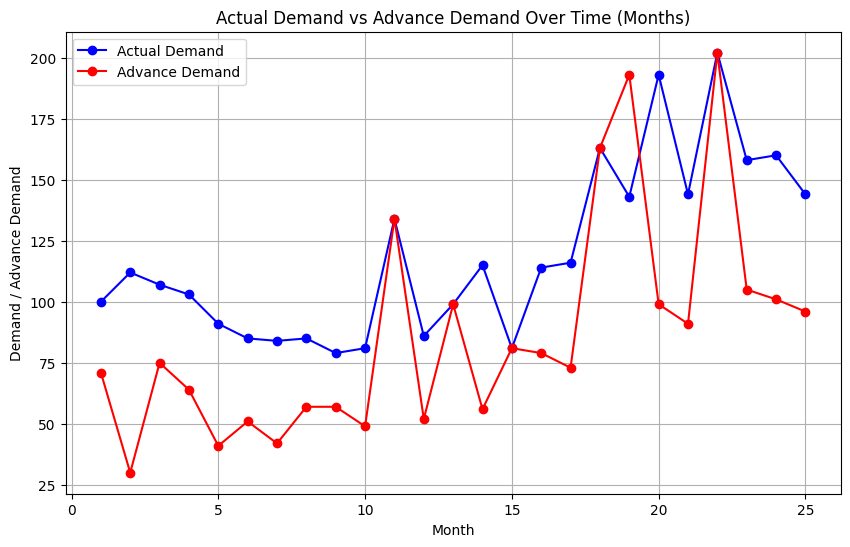

In [9]:
#Line plot of both actual and advanced demand
plt.figure(figsize=(10,6))
plt.plot(df['Month'], df['Demand'], color='blue', marker='o', label='Actual Demand')
plt.plot(df['Month'], df['Advance_demand'], color='red', marker='o', label='Advance Demand')
plt.xlabel('Month')
plt.ylabel('Demand / Advance Demand')
plt.title('Actual Demand vs Advance Demand Over Time (Months)')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
#we setup the features and target variables and split the data
X = df[['Advance_demand']]
y = df['Demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
#Here we initialize and fit the Ridge regression model

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

Ridge()

In [12]:
ridge_preds = ridge_model.predict(X_test)

In [13]:
#Then evaluate the model through the RMSE

ridge_mse = mean_squared_error(y_test, ridge_preds)
ridge_rmse = np.sqrt(ridge_mse)

In [14]:
ridge_rmse

np.float64(19.869757857588905)

In [15]:
#In order to plot the actual vs predicted demand we need to sort the test data first 

sorted_idx = np.argsort(X_test['Advance_demand'].values)
X_test_sorted = X_test['Advance_demand'].values[sorted_idx]
y_test_sorted = y_test.values[sorted_idx]
ridge_preds_sorted = ridge_preds[sorted_idx]

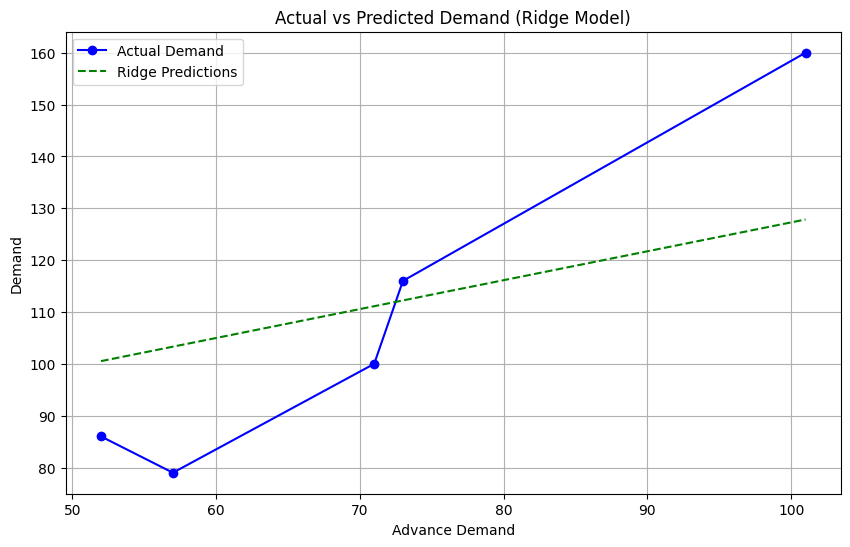

In [16]:
# Line Plot of Actual vs Predicted Demand (for Ridge)
plt.figure(figsize=(10,6))
plt.plot(X_test_sorted, y_test_sorted, color='blue', marker='o', label='Actual Demand')
plt.plot(X_test_sorted, ridge_preds_sorted, color='green', linestyle='--', label='Ridge Predictions')
plt.xlabel('Advance Demand')
plt.ylabel('Demand')
plt.title('Actual vs Predicted Demand (Ridge Model)')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
#Summary of results for Ridge Regularization model

ridge_results = {
    'Ridge RMSE': ridge_rmse,
    'Ridge Coefficient': ridge_model.coef_,
    'Ridge Intercept': ridge_model.intercept_
}

ridge_results

{'Ridge RMSE': np.float64(19.869757857588905),
 'Ridge Coefficient': array([0.55744378]),
 'Ridge Intercept': np.float64(71.53495471659713)}

Now that we've completed the forecasting using the Ridge regularization method, we can add some additional constraints where predicted demand cannot be lower than the advance demand which is a realistic business demand. This way we can create our own customized enhanced regularization method to create the optimal forecasting model. 

In [18]:
# New Step: Custom loss function with penalty for predicted demand < advance demand
def custom_loss_function(params, X, y, advance_demand):
    ridge_model = Ridge(alpha=params[0])  # Alpha (regularization strength) is the first parameter
    ridge_model.fit(X, y)
    predictions = ridge_model.predict(X)
    
    # Calculate MSE (Mean Squared Error)
    mse = mean_squared_error(y, predictions)
    
    # Custom penalty: Add a penalty when predicted demand < advance demand
    penalty = np.sum(np.maximum(advance_demand - predictions, 0))  # Penalty for violating the constraint
    
    # Combine MSE and the penalty. The second parameter in 'params' is the penalty weight (lambda).
    return mse + params[1] * penalty

In [19]:
#Optimize regularization (alpha) and penalty weight (lambda) with constraints
initial_params = [1.0, 0.1]  # Initial guess for alpha (Ridge) and lambda (penalty weight)
bounds = [(0, None), (0, None)]  # Alpha and lambda should both be non-negative


In [20]:
# Run the optimization with bounds
result = minimize(custom_loss_function, initial_params, args=(X_train, y_train, X_train['Advance_demand']), bounds=bounds)

In [21]:
# Optimal alpha and lambda found from optimization
optimal_alpha = result.x[0]  # Optimized Ridge regularization parameter (alpha)
optimal_lambda = result.x[1]  # Optimized penalty weight (lambda)

In [23]:
# Refit the Ridge model with the optimized alpha
ridge_model = Ridge(alpha=optimal_alpha)
ridge_model.fit(X_train, y_train)


enhanced_ridge_preds = ridge_model.predict(X_test)
enhanced_ridge_rmse = np.sqrt(mean_squared_error(y_test, enhanced_ridge_preds))

In [24]:
# Here we make new predictions based off the new optimal model
enhanced_ridge_preds = ridge_model.predict(X_test)
enhanced_ridge_rmse = np.sqrt(mean_squared_error(y_test, enhanced_ridge_preds))

In [25]:
# Summary of optimal Ridge model results
print("Enhanced Ridge Model with Penalty:")
print(f"Optimal Alpha: {optimal_alpha}")
print(f"Optimal Lambda: {optimal_lambda}")
print(f"RMSE: {enhanced_ridge_rmse}")
print(f"Coefficient: {ridge_model.coef_}")
print(f"Intercept: {ridge_model.intercept_}")

Enhanced Ridge Model with Penalty:
Optimal Alpha: 0.9996416138158469
Optimal Lambda: 0.0
RMSE: 19.869757775746727
Coefficient: [0.55744378]
Intercept: 71.53495432158851


In [27]:
#Next we plot the enhanced Ridge model but first we need to smooth the prediction plotting line

sorted_idx = np.argsort(X_test['Advance_demand'].values)
X_test_sorted = X_test['Advance_demand'].values[sorted_idx]
y_test_sorted = y_test.values[sorted_idx]
enhanced_ridge_preds_sorted = enhanced_ridge_preds[sorted_idx]

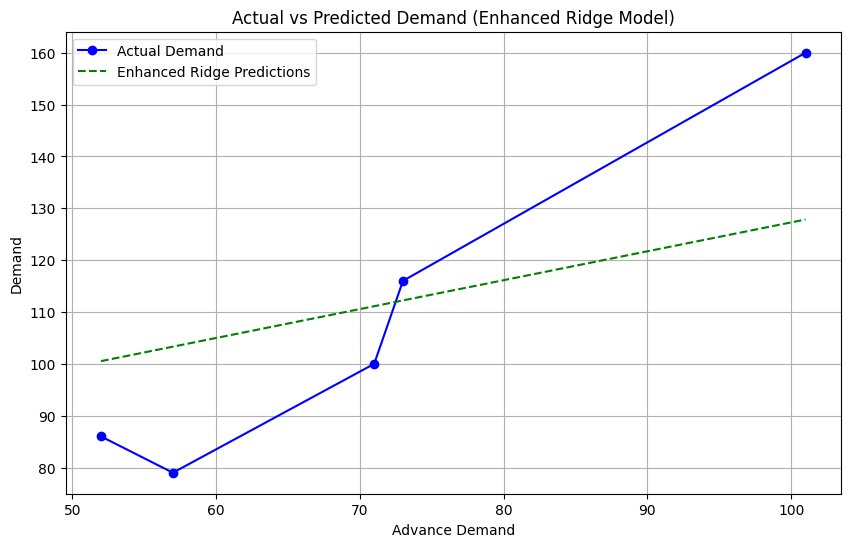

In [28]:
# Line Plot of Actual vs Predicted Demand (for the Enhanced Ridge Model)
plt.figure(figsize=(10,6))
plt.plot(X_test_sorted, y_test_sorted, color='blue', marker='o', label='Actual Demand')
plt.plot(X_test_sorted, enhanced_ridge_preds_sorted, color='green', linestyle='--', label='Enhanced Ridge Predictions')
plt.xlabel('Advance Demand')
plt.ylabel('Demand')
plt.title('Actual vs Predicted Demand (Enhanced Ridge Model)')
plt.grid(True)
plt.legend()
plt.show()